In [140]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pickle

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB


from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

# from sklearn.model_selection import GridSearchCV
# import plotly.express as px
# import plotly.express as px
# import plotly.figure_factory as ff

sns.set()

# Read data

In [141]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')
y_test = pd.read_csv('data/submit.csv')

test['label'] = y_test['label']

train.head()

,id,title,author,text,label
0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1
1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0
2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1
3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1
4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1


# Delete NaN value

In [142]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20800 entries, 0 to 20799
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20800 non-null  int64 
 1   title   20242 non-null  object
 2   author  18843 non-null  object
 3   text    20761 non-null  object
 4   label   20800 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 812.6+ KB


In [143]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5200 entries, 0 to 5199
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      5200 non-null   int64 
 1   title   5078 non-null   object
 2   author  4697 non-null   object
 3   text    5193 non-null   object
 4   label   5200 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 203.2+ KB


In [144]:
train.dropna(axis=0, how='any', inplace=True)
test.dropna(axis=0, how='any', inplace=True)

In [145]:
print('Number of NaN values in sets: ', train.isna().sum().sum() + test.isna().sum().sum())

Number of NaN values in sets:  0


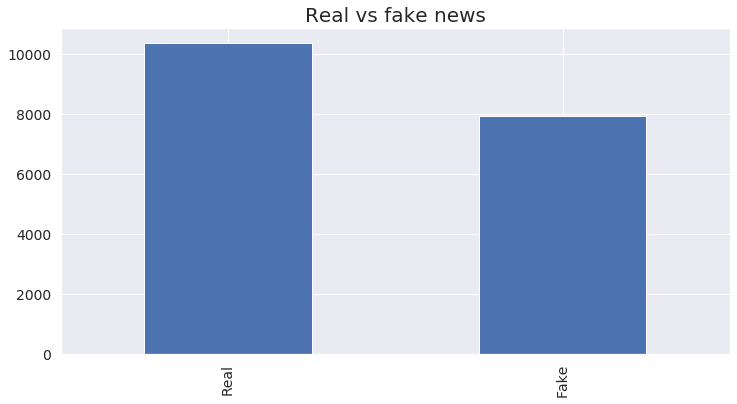

In [146]:
map_values = {
    0: 'Real',
    1: 'Fake'
}

df_t = train.label.value_counts()
df_t.index = df_t.index.map(map_values)

plt.figure(figsize=(12, 6))
df_t.plot(kind='bar', fontsize=14)
plt.title("Real vs fake news", fontsize=20)
plt.show()

# Create object TfidfVectorizer

In [147]:
vectorizer = TfidfVectorizer()

train_vecotorizer = vectorizer.fit_transform(train['text'].astype('U'))
test_vecotorizer = vectorizer.transform(test['text'].astype('U'))

# Create models

## PassiveAggressiveClassifier

In [148]:
pac = PassiveAggressiveClassifier(max_iter=88)
pac.fit(train_vecotorizer, train['label'] )

# params_grid = {
#     'max_iter': np.arange(50, 200, 1)
# }

# grid_search = GridSearchCV(pac, params_grid, scoring='accuracy', n_jobs=-1, cv=5)
# grid_search.fit(train_vecotorizer, train['label'] )

PassiveAggressiveClassifier(max_iter=88)

In [149]:
# grid_search.best_params_

Compare the model on test data

In [150]:
pac_score = pac.score(test_vecotorizer, test['label'].values)
pac_score


0.612896174863388

## Logistic Regression

In [151]:
log_reg = LogisticRegression()

log_reg.fit(train_vecotorizer, train['label'])
lg_score = log_reg.score(test_vecotorizer, test['label'])
lg_score

0.614207650273224

## RandomForestClassifier

In [152]:
rando= RandomForestClassifier(n_estimators=5)
rando.fit(train_vecotorizer, train['label'])
rando_score = rando.score(test_vecotorizer ,test['label'])
rando_score

0.6194535519125683

## MultinomialNB

In [153]:
classifier = MultinomialNB()
classifier.fit(train_vecotorizer, train['label'] )
multi_score = classifier.score(test_vecotorizer, test['label'])
multi_score 

0.5696174863387978

## Choosing the best model

In [154]:
models_value = {'PassiveAggressiveClassifier': pac_score, 'Logistic Regression': lg_score, 'RandomForestClassifier': rando_score, 'MultinomialNB': multi_score}
models = pd.Series(models_value).sort_values(ascending=False)
models

RandomForestClassifier         0.619454
Logistic Regression            0.614208
PassiveAggressiveClassifier    0.612896
MultinomialNB                  0.569617
dtype: float64

In [155]:
models_list = [log_reg, rando, pac, classifier]

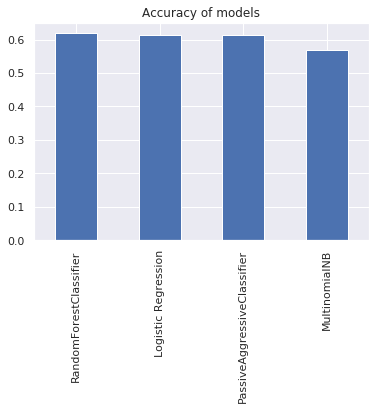

In [156]:
# px.bar(df_models, x='model', y='value', color='value', width=800, height=500, title="Models rank")
plt.figure(figsize=(6, 4))
models.plot(kind='bar')
plt.title('Accuracy of models')
plt.show()

In [157]:
# def plot_confusion_matrix(cm):
#   cm = cm[::-1]
#   cm = pd.DataFrame(cm, columns=['real', 'fake'], index=['fake', 'real'])
#   fig = ff.create_annotated_heatmap(z=cm.values, x=list(cm.columns), y=list(cm.index),
#                                     colorscale='ice', showscale=True, reversescale=True)
#   fig.update_layout(width=400, height=400, title='Confusion Matrix', font_size=16)
#   fig.show()

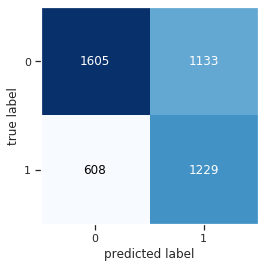

In [158]:
y_pred_rando= rando.predict(test_vecotorizer)
y_pred_pca= pac.predict(test_vecotorizer)

cm_pac = confusion_matrix(y_pred_rando, test['label'])
cm_rando = confusion_matrix(y_pred_pca, test['label'])

plot_confusion_matrix(cm_pac)
plt.show()

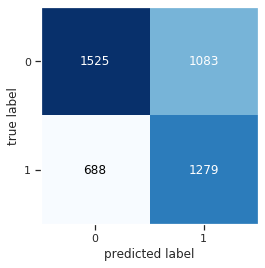

In [159]:
plot_confusion_matrix(cm_rando)
plt.show()

# Test models on test data (outer data)

In [160]:
fake = pd.read_csv('data/production/Fake.csv')
true = pd.read_csv('data/production/True.csv')

In [161]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [162]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [163]:
# fake['text'][0]
# true['text'][1000]

In [164]:
def predict_data(data, vectorizer, classifier):
    text = vectorizer.transform(data.astype('U'))
    y_pred = classifier.predict(text)
    return (round(y_pred.sum() / len(data) * 100, 2))


def exec_models(models_name, models):
    df = pd.DataFrame(data=0, columns=['Fake news predict as fake', 'True news predict as true'], index=models_name)
    
    for i in range(len(models)):
        f = predict_data(fake['text'], vectorizer, models[i])
        t = predict_data(true['text'], vectorizer, models[i])
        
        df.loc[models_name[i]] = [f, t]
        
        print('\n{}'.format(models_name[i]))
        print("Fake news predict as fake: {}%".format( f  ))
        print("True news predict as true: {}%".format( 100 - t ))
    
    return df

df_result = exec_models(list(models.index), models_list)
df_result



RandomForestClassifier
Fake news predict as fake: 66.03%
True news predict as true: 87.74%

Logistic Regression
Fake news predict as fake: 52.08%
True news predict as true: 71.44%

PassiveAggressiveClassifier
Fake news predict as fake: 70.62%
True news predict as true: 80.75%

MultinomialNB
Fake news predict as fake: 4.99%
True news predict as true: 99.83%


,Fake news predict as fake,True news predict as true
RandomForestClassifier,66.03,12.26
Logistic Regression,52.08,28.56
PassiveAggressiveClassifier,70.62,19.25
MultinomialNB,4.99,0.17


In [165]:
df_result['mean'] = df_result[['Fake news predict as fake', 'True news predict as true']].mean(axis=1)
df_result = df_result.sort_values(by='mean', ascending=False)

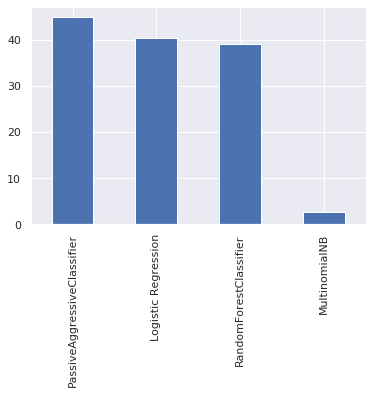

In [166]:
plt.figure(figsize=(6, 4))
_ = df_result['mean'].plot(kind='bar')
plt.show()

# Saving the best model to disk

In [58]:
# saving models to disk
pickle.dump(vectorizer, open('vectorizer.pkl', 'wb'))
pickle.dump(pac, open('model.pkl', 'wb'))

In [59]:
# loading models from disk 
vec = pickle.load( open('vectorizer.pkl', 'rb') )
model = pickle.load( open('model.pkl', 'rb') )

# Checking models

Real news

In [60]:
df_models.modelmsg = pd.DataFrame(index=[0], data=true['text'][100], columns=['data'])
text = vec.transform(msg['data'].astype('U'))
result = model.predict(text)

print("Real (0) Fake (1) news : {}".format( result[0]  ))

Real (0) Fake (1) news : 0


Fake news

In [61]:
msg = pd.DataFrame(index=[0], data=fake['text'][100], columns=['data'])
text = vec.transform(msg['data'].astype('U'))
result = model.predict(text)

print("Real (0) Fake (1) news : {}".format( result[0]  ))

Real (0) Fake (1) news : 1


In [29]:
# true['text'][100],

In [30]:
# fake.text[100]